# iQuHack 2026 - Quantum Entanglement Distillation Game

In this game, you design quantum circuits to distill noisy Bell pairs and claim edges in a network.

**Game Flow**: Register -> Select Starting Node -> Design Circuits -> Claim Edges -> Score Points

In [15]:
from client import GameClient
from visualization import GraphTool
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,qasm2
import json
from pathlib import Path
import numpy as np

## Session Management

Save/load your session to avoid re-registering.

In [16]:
SESSION_FILE = Path("session.json")

def save_session(client):
    if client.api_token:
        with open(SESSION_FILE, "w") as f:
            json.dump({"api_token": client.api_token, "player_id": client.player_id, "name": client.name}, f)
        print(f"Session saved.")

def load_session():
    if not SESSION_FILE.exists():
        return None
    with open(SESSION_FILE) as f:
        data = json.load(f)
    client = GameClient(api_token=data.get("api_token"))
    client.player_id = data.get("player_id")
    client.name = data.get("name")
    status = client.get_status()
    if status:
        print(f"Resumed: {client.player_id} | Score: {status.get('score', 0)} | Budget: {status.get('budget', 0)}")
        return client
    return None

In [17]:
# Try to resume existing session
client = load_session()

if not client:
    print("No saved session. Register below.")

Resumed: QTsQuacking | Score: 0 | Budget: 40


## Step 1: Register

Skip this if you resumed a session above.

In [4]:
if client and client.api_token:
    print(f"Already registered as {client.player_id}")
else:
    client = GameClient()
    
    # CHANGE THESE to your unique values
    PLAYER_ID = "QTsQuacking"
    PLAYER_NAME = "Mohana"
    
    result = client.register(PLAYER_ID, PLAYER_NAME, location=input("remote or in_person: ").strip())
    
    if result.get("ok"):
        print(f"Registered! Token: {client.api_token[:20]}...")
        candidates = result["data"].get("starting_candidates", [])
        print(f"\nStarting candidates ({len(candidates)}):")
        for c in candidates:
            print(f"  - {c['node_id']}: {c['utility_qubits']} qubits, +{c['bonus_bell_pairs']} bonus")
        save_session(client)
    else:
        print(f"Failed: {result.get('error', {}).get('message')}")

Already registered as QTsQuacking


## Step 2: Select Starting Node

In [18]:
status = client.get_status()

if status.get('starting_node'):
    print(f"Starting node: {status['starting_node']}")
    print(f"Budget: {status['budget']} | Score: {status['score']}")
else:
    print("Select a starting node from the candidates shown above.")
    # Uncomment and modify:
    result = client.select_starting_node("Delft, Netherlands")
    print(result)

Starting node: Delft, Netherlands
Budget: 40 | Score: 0


## Step 3: Explore the Network

In [19]:
client.print_status()

Player: QTsQuacking (Mohana)
Score: 0 | Budget: 40 bell pairs
Active: Yes
Starting node: Delft, Netherlands
Owned: 1 nodes, 0 edges
Claimable edges: 4
  - ['Amsterdam, Netherlands', 'Delft, Netherlands']: threshold=0.90, difficulty=1
  - ['Delft, Netherlands', 'Rotterdam, Netherlands']: threshold=0.90, difficulty=1
  - ['Delft, Netherlands', 'Leiden, Netherlands']: threshold=0.90, difficulty=1
  ... and 1 more


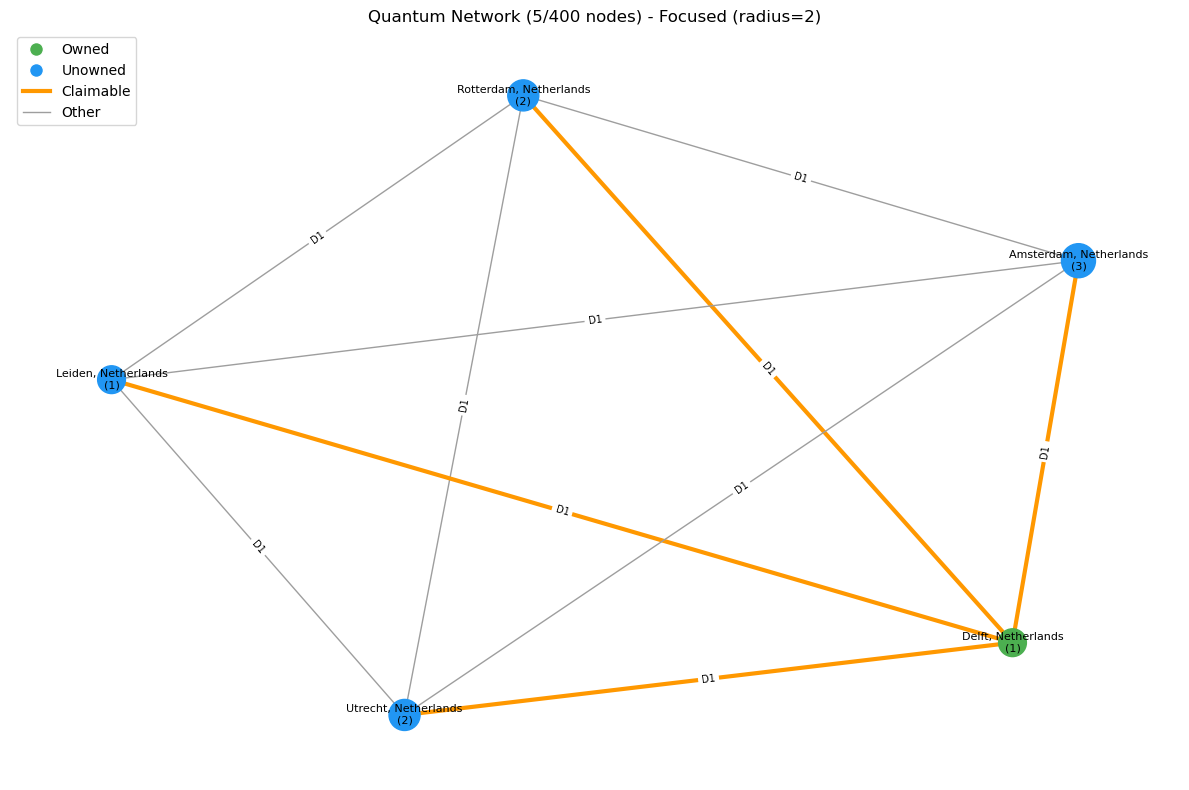

In [20]:
# Visualize the network (focused around your nodes)
viz = GraphTool(client.get_cached_graph())
owned = set(client.get_status().get('owned_nodes', []))
viz.render(owned)

## Step 4: Design a Distillation Circuit

For N Bell pairs, qubits are paired outside-in:
- Pair 0: qubits {0, 2N-1}
- Pair 1: qubits {1, 2N-2}
- ...
- Final pair: qubits {N-1, N}

Design a circuit that improves fidelity through LOCC operations.

In [36]:
def create_distillation_circuit(num_rounds):
    num_pairs = num_rounds + 1
    pair_qubits = 2 * num_pairs 
    qr = QuantumRegister(pair_qubits + 1, 'q')
    cr_size = 2 * num_rounds + 1
    cr = ClassicalRegister(cr_size, 'c')
    qc = QuantumCircuit(qr, cr)

    flag_bit_index = cr_size - 1 
    
    def get_pair(i):
        return (i, pair_qubits - 1 - i)
    
    surv_A, surv_B = get_pair(num_rounds)
    
    # Basis change
    qc.rx(np.pi/2, surv_A)
    qc.rx(-np.pi/2, surv_B)
    
    for i in range(num_rounds):
        sac_A, sac_B = get_pair(i)
        qc.rx(np.pi/2, sac_A)
        qc.rx(-np.pi/2, sac_B)
        qc.cx(surv_A, sac_A)
        qc.cx(surv_B, sac_B)
    
    for i in range(num_rounds):
        sac_A, sac_B = get_pair(i)
        qc.measure(sac_A, mA[i])
        with qc.if_test((mA[i], 1)):
            qc.x(sac_B)  
        qc.measure(sac_B, parity[i])  

    scratch = 0
    qc.reset(scratch)
    for val in range(1, 1 << num_rounds):
        with qc.if_test((parity, val)):
            qc.x(scratch)
    qc.measure(scratch, flag[0])
            
    return qc

def get_target_node(edge, owned_nodes):
    n1, n2 = edge['edge_id']
    return n2 if n1 in owned_nodes else n1    


## Step 5: Claim an Edge

In [37]:

claimable = client.get_claimable_edges()
claimable_sorted = sorted(claimable, key=lambda e: (e['difficulty_rating'], e['base_threshold']))

print(f"Claimable edges ({len(claimable)}):")
for edge in claimable_sorted[:5]:
    print(f"  {edge['edge_id']} - threshold: {edge['base_threshold']:.3f}, difficulty: {edge['difficulty_rating']}")

Claimable edges (4):
  ['Amsterdam, Netherlands', 'Delft, Netherlands'] - threshold: 0.900, difficulty: 1
  ['Delft, Netherlands', 'Rotterdam, Netherlands'] - threshold: 0.900, difficulty: 1
  ['Delft, Netherlands', 'Leiden, Netherlands'] - threshold: 0.900, difficulty: 1
  ['Delft, Netherlands', 'Utrecht, Netherlands'] - threshold: 0.900, difficulty: 1


In [38]:
# Claim an edge
if claimable:
    target = claimable_sorted[2]  # Easiest edge
    edge_id = tuple(target['edge_id'])

    num_rounds = 2
    circuit = create_distillation_circuit(num_rounds)
    num_bell_pairs = num_rounds + 1
    flag_bit = 0  # Classical bit for post-selection (keep when flag=0)
    print(f"Submitting circuit with {circuit.num_qubits} qubits and {circuit.size()} gates.")
    
    print(f"Claiming {edge_id} (threshold: {target['base_threshold']:.3f})...")
    
    result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)
    
    if result.get("ok"):
        data = result["data"]
        print(f"Success: {data.get('success')}")
        print(f"Fidelity: {data.get('fidelity', 0):.4f} (threshold: {data.get('threshold', 0):.4f})")
        print(f"Success probability: {data.get('success_probability', 0):.4f}")
    else:
        print(f"Error: {result.get('error', {}).get('message')}")

NameError: name 'parity' is not defined

## Step 6: Check Progress

In [20]:
client.print_status()

Player: QTsQuacking (Mohana)
Score: 0 | Budget: 40 bell pairs
Active: Yes
Starting node: Delft, Netherlands
Owned: 1 nodes, 0 edges
Claimable edges: 4
  - ['Amsterdam, Netherlands', 'Delft, Netherlands']: threshold=0.90, difficulty=1
  - ['Delft, Netherlands', 'Rotterdam, Netherlands']: threshold=0.90, difficulty=1
  - ['Delft, Netherlands', 'Leiden, Netherlands']: threshold=0.90, difficulty=1
  ... and 1 more


In [12]:
# View leaderboard
leaderboard = client.get_leaderboard()["leaderboard"]
print("Leaderboard:")
for i, p in enumerate(leaderboard[:10]):
    print(f"{i+1}. {p.get('player_id', 'Unknown'):20} Score: {p.get('score', 0)}")

Leaderboard:
1. your_unique_id       Score: 0


## Tips

- **Failed attempts are free** - only successful claims cost bell pairs
- **More bell pairs** can improve fidelity but cost more budget
- **Vertex rewards** are competitive - top players by claim strength earn rewards
- **Budget management** is key - if budget reaches 0, you're eliminated

Good luck!

In [13]:
# Restart game (uncomment to use)
# result = client.restart()
# print(result)